# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
!pip install nilearn

import numpy as np
from nilearn import datasets
from nilearn import input_data
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting

     |████████████████████████████████| 2.5MB 2.7MB/s 


In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [ ]:
# fname = "hcp_rest.tgz"
# if not os.path.exists(fname):
#   !wget -qO $fname https://osf.io/bqp7m/download/
#   !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [ ]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [ ]:
# fname = "hcp_covariates.tgz"
# if not os.path.exists(fname):
#   !wget -qO $fname https://osf.io/x5p4g/download/
#   !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [ ]:
fname = f"{HCP_DIR}/atlas.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/j5kuc/download

## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [277]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)
for i in [ 87, 245 ,267 ,355  ,82 ,143 ,259 ,262, 323]:
  print(region_info['name'][i])

R_10v
L_47m
L_10v
L_STSva
R_p9-46v
R_IP2
L_IFJp
L_p9-46v
L_IP2


In [ ]:
with np.load(f"{HCP_DIR}/atlas.npz") as dobj:
  atlas = dict(**dobj)

# Helper functions


## Data loading

In [ ]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  # print(run_ids)
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

## Task-based analysis

In [ ]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]  # <-- new line
    selected_data.append(run_data[:, run_frames])
    
  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

# Resting-state analyses

Load a single run of resting-state data:

In [ ]:
# help(load_timeseries)

Help on function load_timeseries in module __main__:

load_timeseries(subject, name, runs=None, concat=True, remove_mean=True)
    Load timeseries data for a single subject.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of experiment ("rest" or name of task) to load
      run (None or int or list of ints): 0-based run(s) of the task to load,
        or None to load all runs.
      concat (bool) : If True, concatenate multiple runs in time
      remove_mean (bool) : If True, subtract the parcel-wise mean
    
    Returns
      ts (n_parcel x n_tp array): Array of BOLD data values



In [ ]:
# timeseries = load_timeseries(subject=0, name="rest", runs=1)
# print(timeseries.shape)  # n_parcel x n_timepoint

(360, 1200)


Load a concatenated resting-state timeseries (using all runs' data) for each subject:

In [ ]:
# timeseries_rest = []
# for subject in subjects:
#   ts_concat = load_timeseries(subject, "rest")
#   timeseries_rest.append(ts_concat)

## Run a simple correlation-based "functional connectivity" analysis

Generate a correlation matrix (showing "functional connectivity" or FC) for each subject and plot the group average:

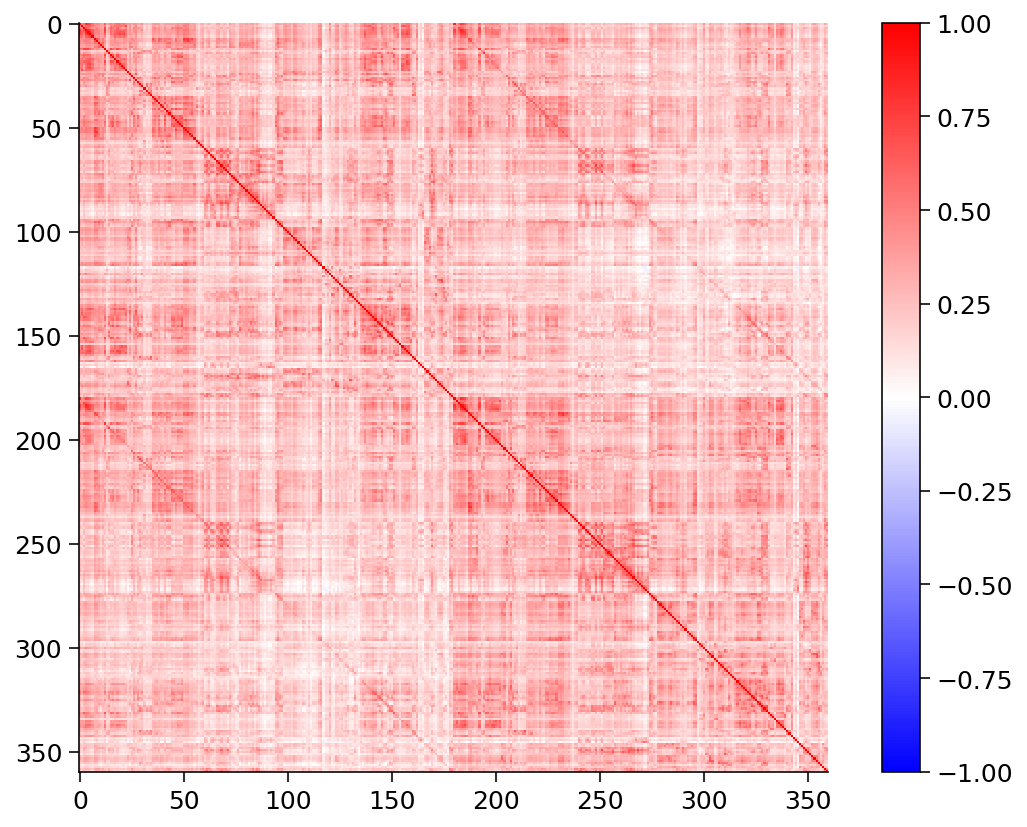

In [ ]:
# fc = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
# for sub, ts in enumerate(timeseries_rest):
#   fc[sub] = np.corrcoef(ts)

# group_fc = fc.mean(axis=0)

# plt.imshow(group_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
# plt.colorbar()
# plt.show()

## Visualizing using nilearn

In [ ]:
!pip install nilearn
import nilearn.plotting

     |████████████████████████████████| 2.5MB 2.7MB/s 


In [ ]:
# nilearn.plotting.view_connectome(adjacency_matrix = group_fc, node_coords=coords,edge_threshold='99%')

Plot the profile of FC values between a particular "seed" parcel and every parcel in the dataset, separated by hemisphere:

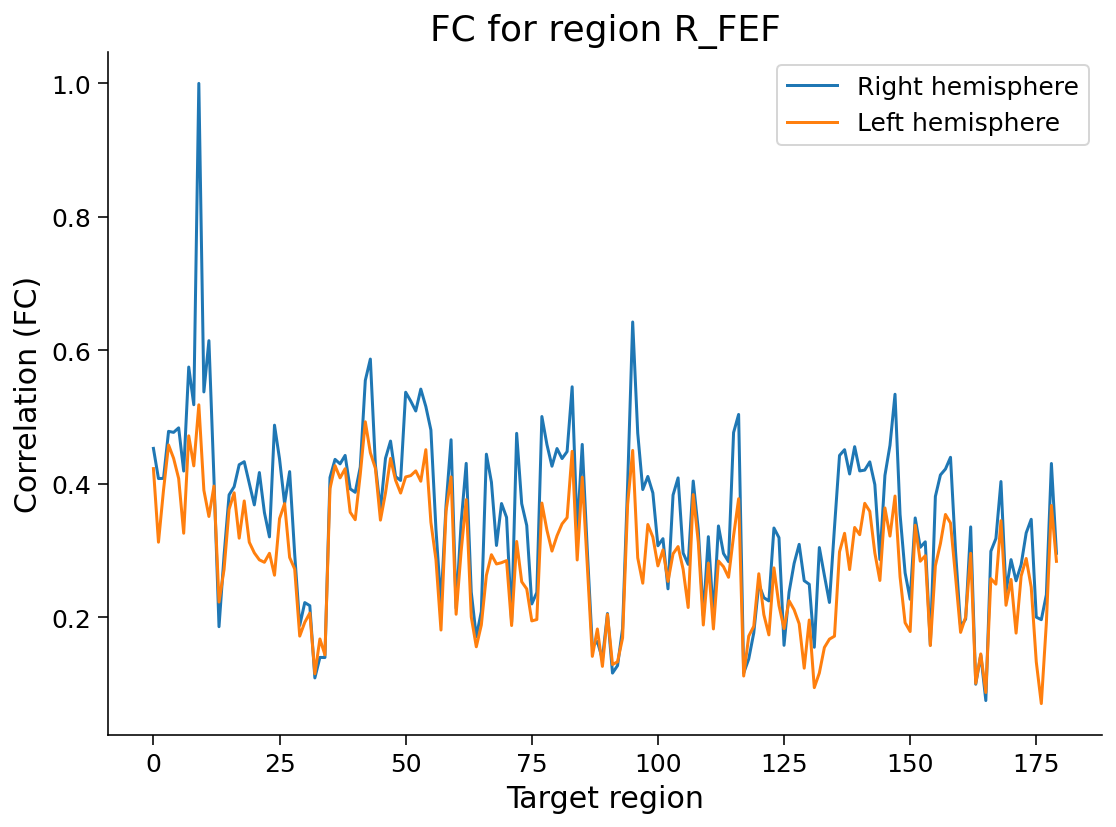

In [ ]:
seed_roi = "R_FEF"  # name of seed parcel
ind = region_info["name"].index(seed_roi)

hemi_fc = np.split(group_fc, 2)

# Plot the FC profile across the right and left hemisphere target regions
for i, hemi_fc in enumerate(hemi_fc):
  plt.plot(hemi_fc[:, ind], label=f"{HEMIS[i]} hemisphere")
plt.title(f"FC for region {seed_roi}")
plt.xlabel("Target region")
plt.ylabel("Correlation (FC)")
plt.legend()
plt.show()

# Task analyses

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools, 
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

## Load individual runs for a given task

Load each subject's data for a specific task, separately for each run:

In [ ]:
timeseries_task = []
for subject in subjects:
  timeseries_task.append(load_timeseries(subject, "language", concat=False))

## Run a simple subtraction analysis

In [ ]:
help(load_evs)

Help on function load_evs in module __main__:

load_evs(subject, name, condition)
    Load EV (explanatory variable) data for one task condition.
    
    Args:
      subject (int): 0-based subject ID to load
      name (str) : Name of task
      condition (str) : Name of condition
    
    Returns
      evs (list of dicts): A dictionary with the onset, duration, and amplitude
        of the condition for each run.



In [ ]:
help(selective_average)

Help on function selective_average in module __main__:

selective_average(timeseries_data, ev, skip=0)
    Take the temporal mean across frames for a given condition.
    
    Args:
      timeseries_data (array or list of arrays): n_parcel x n_tp arrays
      ev (dict or list of dicts): Condition timing information
      skip (int) : Ignore this many frames at the start of each trial, to account
        for hemodynamic lag
    
    Returns:
      avg_data (1D array): Data averagted across selected image frames based
      on condition timing



In [ ]:
task = "language"
conditions = ["story", "math"]  # Run a substraction analysis between two conditions

contrast = []
for subject in subjects:

  # Get the average signal in each region for each condition
  evs = [load_evs(subject, task, cond) for cond in conditions]
  avgs = [selective_average(timeseries_task[subject], ev) for ev in evs]

  # Store the region-wise difference
  contrast.append(avgs[0] - avgs[1])

group_contrast = np.mean(contrast, axis=0)

Plot group-averaged contrast value across regions:

77.97112254435294
64.54721016899695


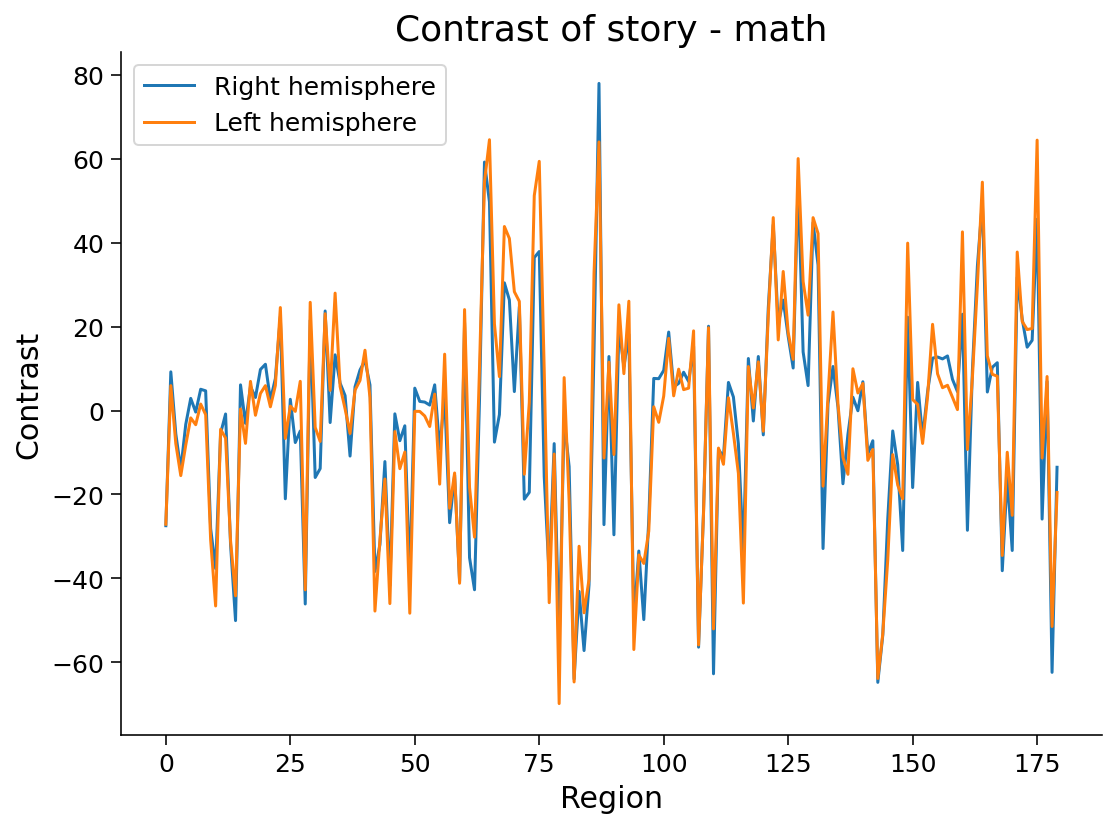

In [ ]:
hemi_contrasts = np.split(group_contrast, 2)

for i, hemi_contrast in enumerate(hemi_contrasts):
  plt.plot(hemi_contrast, label=f"{HEMIS[i]} hemisphere")

# imp_parcel = np.concatenate((np.where(hemi_contrasts[0]>30), np.where(hemi_contrasts[1]>30)), axis=1)
# imp_parcel = np.concatenate((imp_parcel,np.where(hemi_contrasts[0]<-30)),axis=1)
# imp_parcel = np.concatenate((imp_parcel,np.where(hemi_contrasts[1]<-30)),axis=1)
# print(imp_parcel)
print(max(hemi_contrasts[0]))
print(max(hemi_contrasts[1]))
plt.title("Contrast of %s - %s" % (conditions[0], conditions[1]))
plt.xlabel("Region")
plt.ylabel('Contrast')
plt.legend()
plt.show()

In [ ]:
fsaverage = datasets.fetch_surf_fsaverage()
# print(fsaverage[''])
surf_contrast = group_contrast[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_right'],
                   surf_contrast,
                   vmax=80)

## Characterize values by functional network

Average the contrast values within parcels belonging to each network and plot:

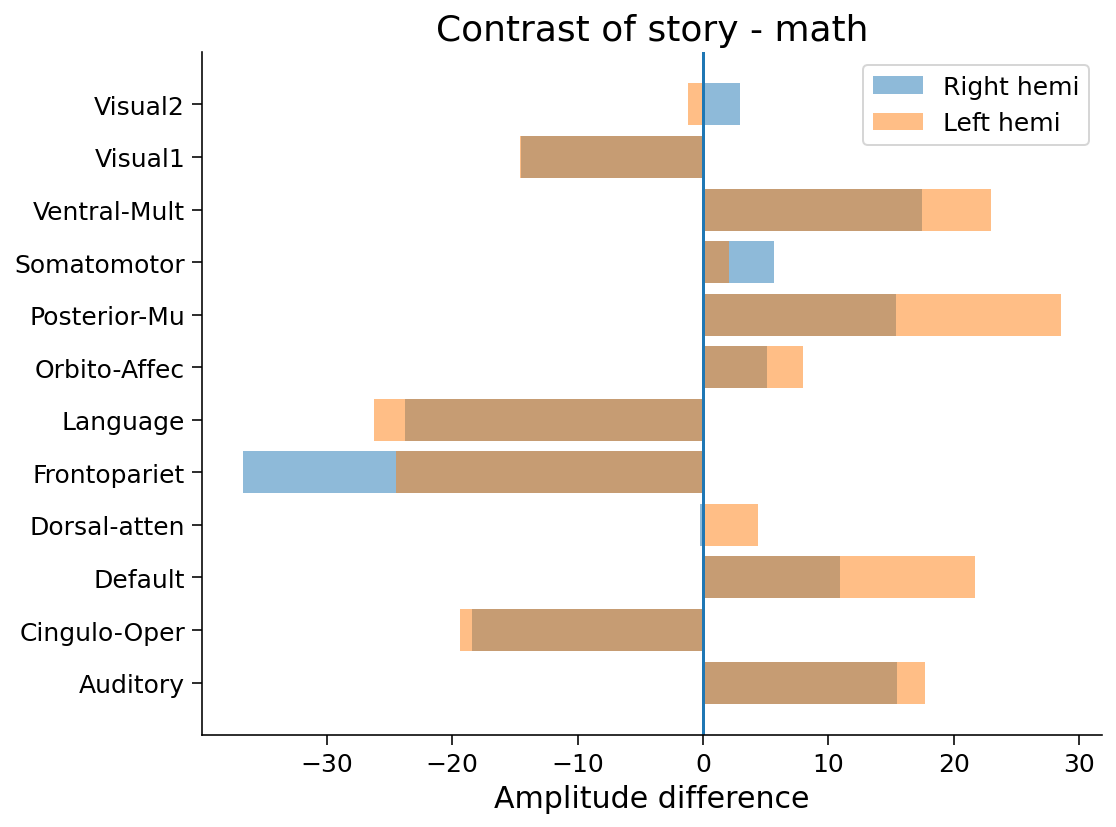

In [ ]:
# Get unique network labels
network_names = np.unique(region_info["network"])

hemi_networks = np.split(region_info["network"], 2)
hemi_contrasts = np.split(group_contrast, 2)

# Get and plot mean contrast value per network, by hemisphere
for hemi, hemi_network, hemi_contrast in zip(HEMIS, hemi_networks, hemi_contrasts):
  network_vals = []
  for network in network_names:
    network_vals.append(hemi_contrast[hemi_network == network].mean())
  plt.barh(network_names, network_vals, alpha=.5, label=f"{hemi} hemi")

plt.axvline(0)
plt.xlabel("Amplitude difference")
plt.title(f"Contrast of {conditions[0]} - {conditions[1]}")
plt.legend()
plt.show()

# Behavioral covariates


## Task performance measures

The dataset also includes aggregate behavior for each task run stored in task-specific `.csv` files. It is possible to load and work with these files using `numpy`:

In [ ]:
lang_behavior = np.genfromtxt("hcp/behavior/language.csv",
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
print(lang_behavior[:5])
print(lang_behavior.dtype.names)

[(0, 0, 'MATH', 0.875     , 2.42857143, 3713.5)
 (0, 0, 'STORY', 1.        , 9.28571429, 3002. )
 (0, 1, 'MATH', 0.72727273, 2.        , 3694. )
 (0, 1, 'STORY', 0.75      , 8.5       , 2759.5)
 (1, 0, 'MATH', 0.88888889, 3.71428571, 3985. )]
('Subject', 'Run', 'ConditionName', 'ACC', 'AVG_DIFFICULTY_LEVEL', 'MEDIAN_RT')


But, while not formally taught as part of the course, [`pandas`](https://pandas.pydata.org/) offers more powerful tools for tabular data analysis.

## Pseudo-demographics

The NMA-distributed version of the HCP data does not contain any real demographic information. But we have created a synthetic dataset of 25 "demographic" variables based on a model trained on the original dataset to predict demographics from resting-state network organization measures:

In [ ]:
demo = np.load("hcp/pseudo_demographics.npy")
demo.shape

## Original subject IDs

The dataset also contains a key to map the ordinal subject numbers to the IDs used in the original HCP dataset:

In [ ]:
ids = np.loadtxt("hcp/orig_ids.txt")
print(ids[:8])

[199453. 580751. 173435. 919966. 181636. 192843. 894067. 174437.]


In [ ]:
def visualising_connectome(timeseries):

  url = ("https://gist.githubusercontent.com/mwaskom/cb78082d7eede47bed54866fd8cb06b3/raw/9c39627d84c20e65101fff49fe67adb76d6e4155/glasser_coords.txt")
  coords = np.loadtxt(url)
  connectivity_measure = ConnectivityMeasure(kind='covariance')
  correlation_matrix = connectivity_measure.fit_transform([timeseries.T])[0]

  # Plot connectivity matrix (use plot_matrix)
  plotting.plot_matrix(correlation_matrix, vmin=-1)
  plotting.show()
  print(correlation_matrix.shape)

  # power = datasets.load_mni152_brain_mask()
  # coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

  plotting.plot_connectome(correlation_matrix, node_coords=coords,edge_threshold='99%', colorbar=True)
  plotting.show()

  plotting.view_connectome(correlation_matrix, node_coords=coords,edge_threshold='99%')

## t-SNE plots

In [ ]:
def visualize_components(component1, component2, labels, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure(figsize=(15,10))
  cmap = plt.cm.get_cmap('viridis')
  plt.scatter(x=component1, y=component2, c=labels, cmap=cmap,)
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.colorbar(ticks=range(10))
  plt.clim(1, 316)
  # n=range(len(component1))
  # for i, txt in enumerate(index):
  #   # print(txt)

  #   plt.annotate(str(txt), (component1[i], component2[i]))
  if show:
    plt.show()

In [ ]:
def add_timestamps(timeseries):
  #adding timestamp number as labels for trajectory visualization
  temp = timeseries.T
  labels = np.array(range(temp.shape[0])).reshape(temp.shape[0],1)
  timeseries_new = np.hstack((temp, labels))
  # print(timeseries_new.shape)
  return timeseries_new

In [ ]:
def apply_TSNE(data, labels):
  #instantiating t-SNE
  tsne_model = TSNE(n_components=2, perplexity=40, random_state=2020) 

  #performing t-SNE
  embed = tsne_model.fit_transform(data)
  # print(embed.shape)
  visualize_components(embed[:,0],embed[:,1], labels=labels, show=True)

In [ ]:
def get_specific_frames(subject, name, activity, run=1, skip=0):
  #loading evs for that activity
  activity_evs = load_evs(subject, name, activity)

  #getting frames
  activity_frames = np.array(condition_frames([activity_evs[run]], skip))
  return activity_frames

In [ ]:
def get_all_story_math_timestamps_with_labels (n,run, remove_mean = True,name = "language"):

  n_sub_timeseries = np.array([])
  for i in range(n):
    #loading timeseries data for above conditions
    timeseries = load_timeseries(i, name, run,remove_mean)
    # print(timeseries.shape)
    
    #getting frames for story and math tasks
    story_frames = get_specific_frames(i,name,"story", run)
    math_frames = get_specific_frames(i,name,"math", run)

    index = np.zeros(timeseries.shape[1])
    # print("index shape ", index.shape)
    # print("math frames shape ", math_frames[1].shape)
    # index[math_frames[math_frames<316]]=1
    # index[story_frames[story_frames<316]]=-1
    # print(math_frames)
    index[math_frames[math_frames<timeseries.shape[1]]]=1
    index[story_frames[story_frames<timeseries.shape[1]]]=-1

    indices_without_zeros = index!=0
    #0s because of no specific activity

    #removing brain activity at timestamps where label=0
    timeseries_with_nonzero_labels = timeseries[:,indices_without_zeros]
    # print(timeseries_with_nonzero_labels.shape)
    nonzero_indices = index[indices_without_zeros]
    # print(nonzero_indices.shape)
    temp = timeseries_with_nonzero_labels.T
    timeseries_new = np.hstack((temp, nonzero_indices.reshape(temp.shape[0],1)))
    # print(timeseries_new.shape)
    if(i==0):
      n_sub_timeseries = timeseries_new
    else:
      n_sub_timeseries = np.vstack((n_sub_timeseries,timeseries_new))

  return n_sub_timeseries  

In [ ]:
n_sub_timeseries = get_all_story_math_timestamps_with_labels(338,1)
np.random.shuffle(n_sub_timeseries)
print(n_sub_timeseries.shape)

(102123, 361)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(n_sub_timeseries[:,:-1], n_sub_timeseries[:,-1], test_size=0.20, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(81698, 360)
(81698,)
(20425, 360)
(20425,)


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import plot_confusion_matrix


##LDA

In [ ]:
clf = LinearDiscriminantAnalysis(n_components=1, store_covariance=True)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy' + str(accuracy_score(y_test, y_pred)))

[[9352 1272]
 [ 779 9022]]
Accuracy0.8995838433292533


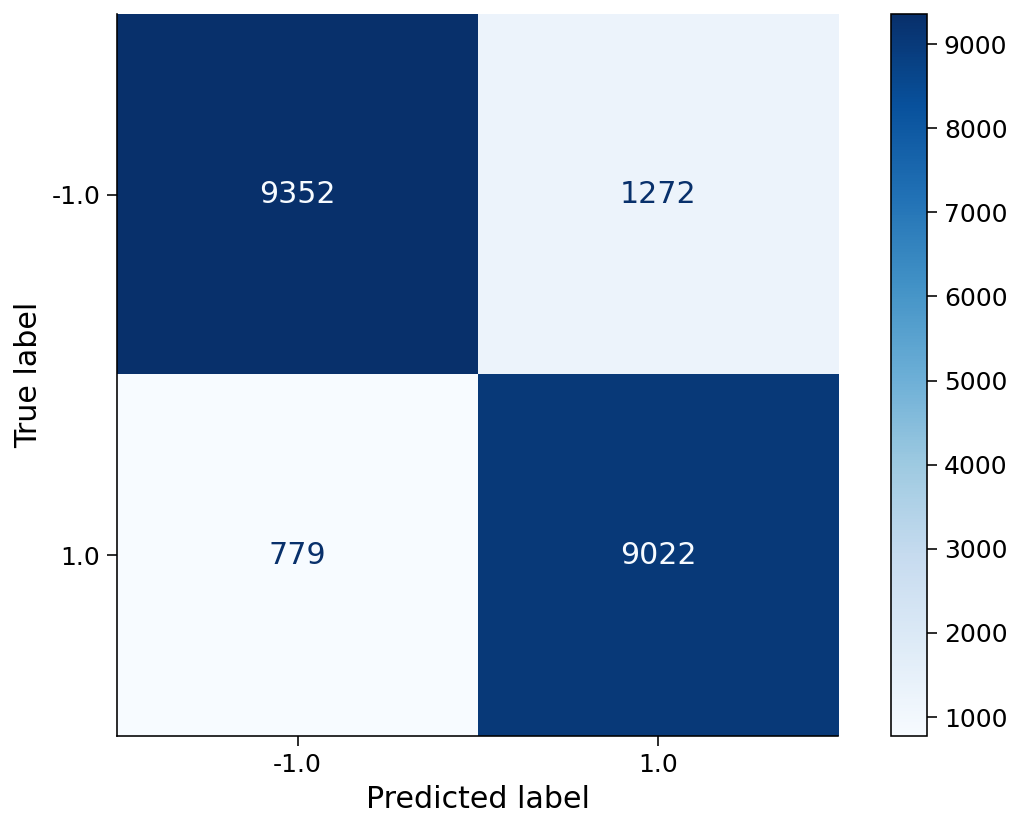

In [ ]:
plot_confusion_matrix(clf, x_test, y_test, cmap=plt.cm.Blues, values_format = '')  # doctest: +SKIP
plt.show()

In [ ]:
l = abs(clf.coef_).argsort()[:,-10:]
print(l[0][::-1])
val = [clf.coef_[0][i]*1000 for i in l]
print(val[0][::-1])
# print(clf.coef_[[0][257,229,174,296,222,354,329,147,24,204]])
print("Top distinguishing regions for math: ")
math_reg=[]
story_reg=[]
for r in l[0][val[0]>0]:
  math_reg = [region_info['name'][r]] + math_reg
print(math_reg)
print("Top distinguishing regions for story: ")
for r in l[0][val[0]<0]:
  story_reg = [region_info['name'][r]] + story_reg
print(story_reg)

[ 24 329 204 147 354 222 296 148 257 174]
[ 8.93085953 -8.75438767  8.1132505  -7.79510111 -7.74251321  6.01734533
  5.83655334 -5.73795842  5.63035046 -4.90383962]
Top distinguishing regions for math: 
['R_PSL', 'L_PSL', 'L_SCEF', 'L_AIP', 'L_6r']
Top distinguishing regions for story: 
['L_PGi', 'R_PF', 'L_A4', 'R_PFm', 'R_A4']


In [ ]:
x_train_tr = clf.transform(x_train)
print(x_train_tr.shape)
x_test_tr = clf.transform(x_test)
print(x_test_tr.shape)
print(x_test_tr[y_test==1])

(81698, 1)
(20425, 1)
[[1.28252562]
 [1.76769556]
 [0.79142022]
 ...
 [1.36715635]
 [2.01284997]
 [1.20649283]]


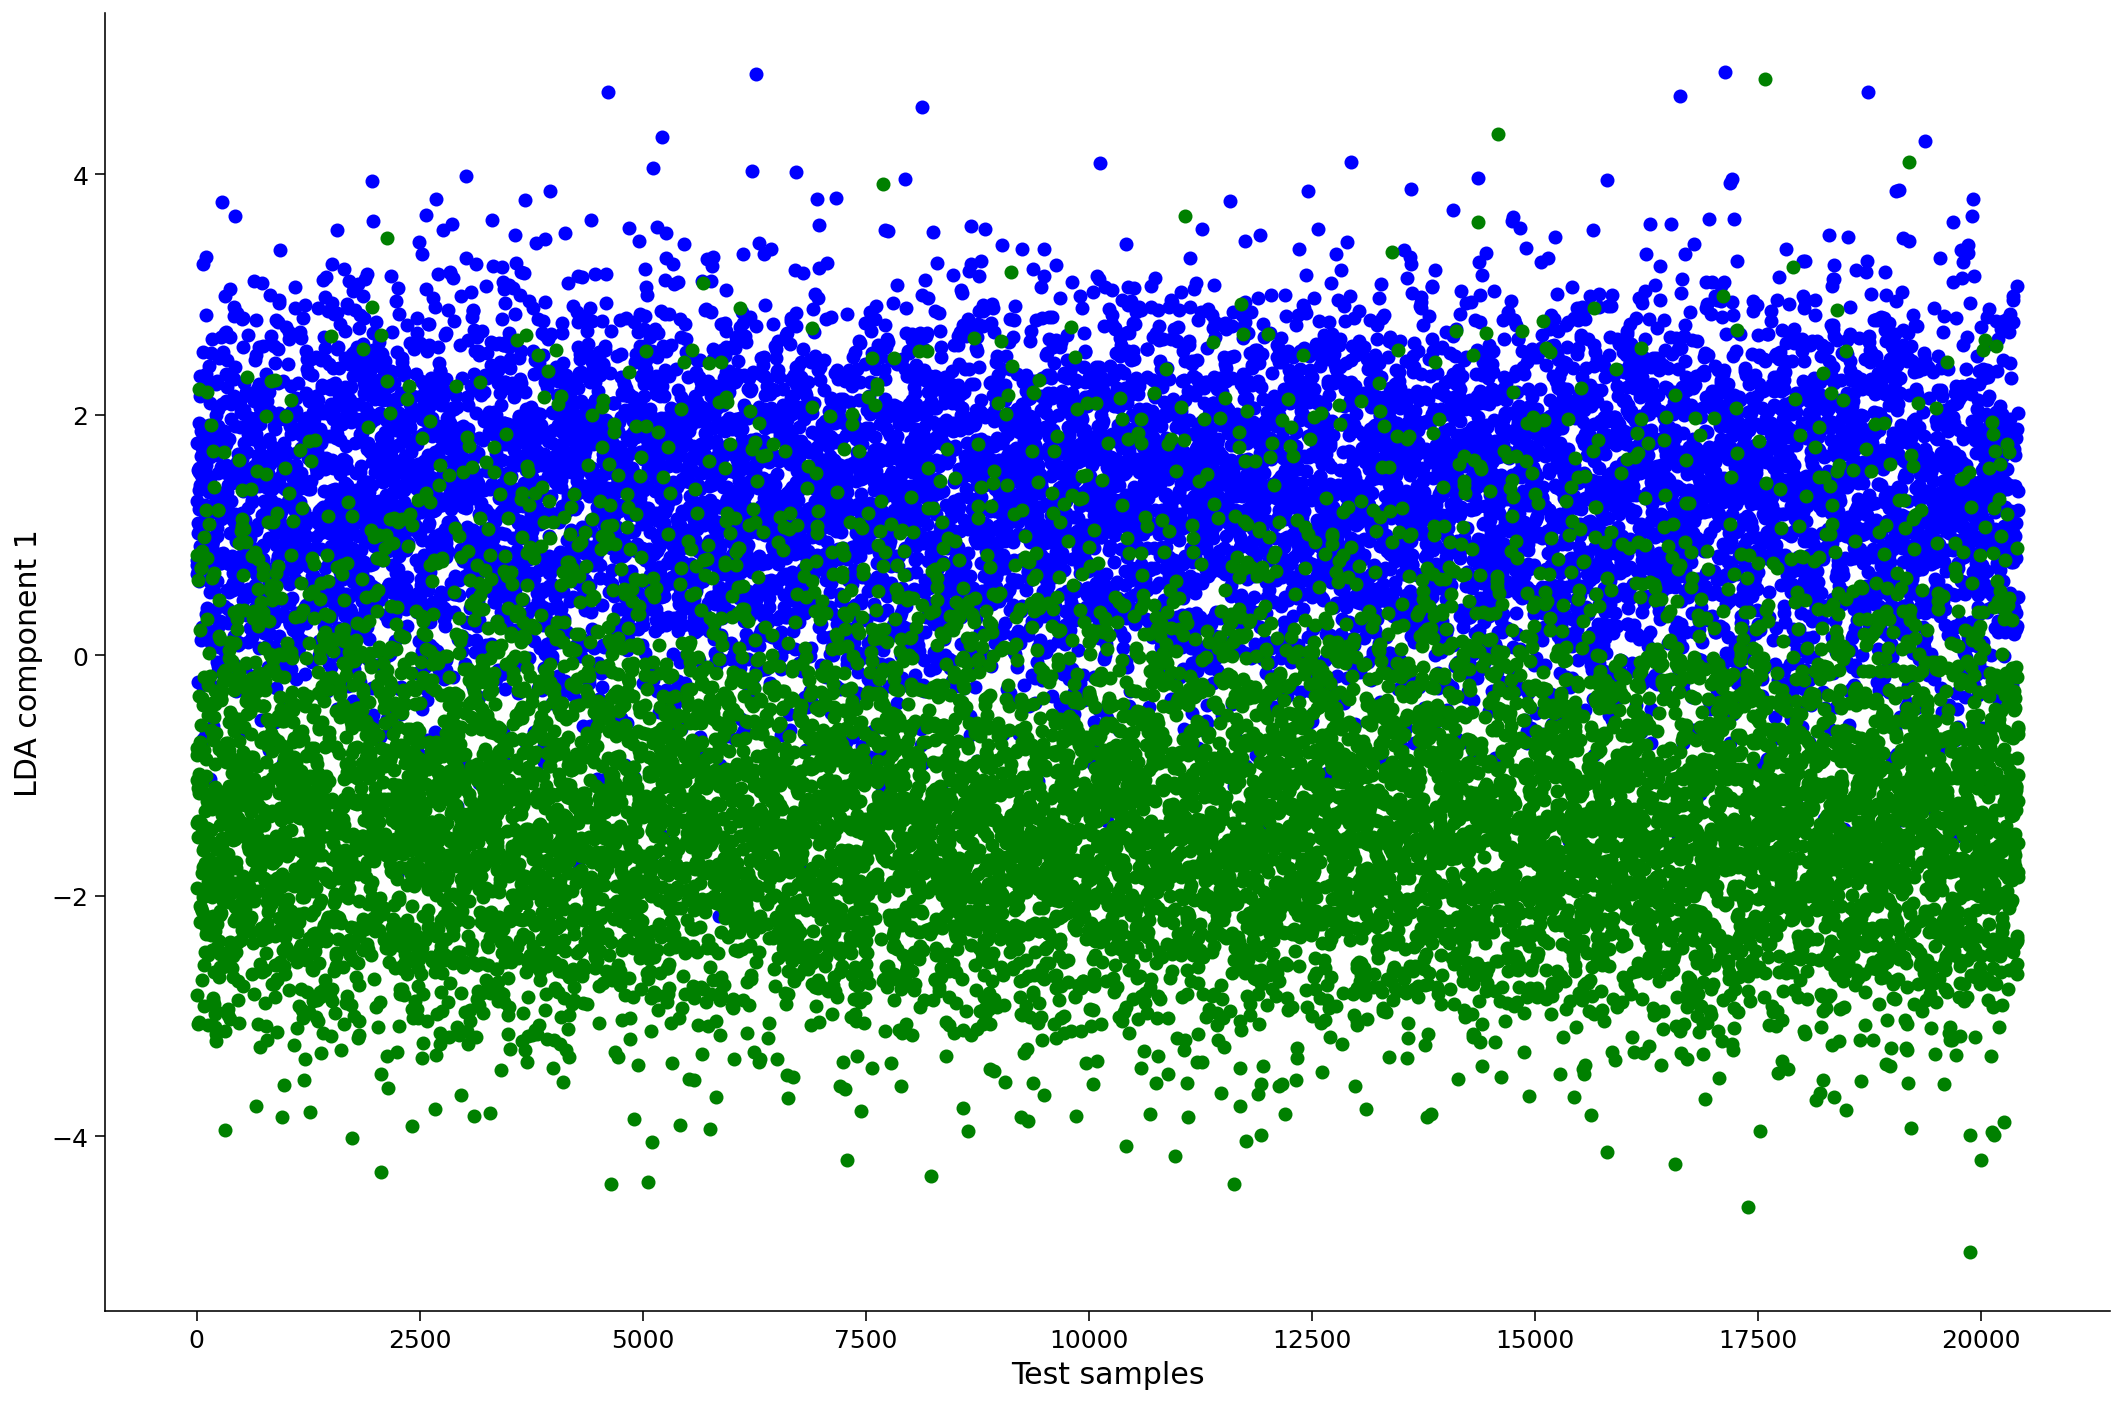

In [ ]:
#visualising LDA

plt.figure(figsize=(15,10))
plt.xlabel('Test samples')
plt.ylabel('LDA component 1')
plt.plot(np.where(y_test==1),x_test_tr[y_test==1].T,'bo', label="math")
plt.plot(np.where(y_test==-1), x_test_tr[y_test==-1].T, 'go', label = "story")
plt.show()

##Linear SVC

In [ ]:
clf_linearSVC = make_pipeline(StandardScaler(), LinearSVC(C =0.001, penalty='l1', dual=False, random_state=0, tol=1e-5, max_iter=10000))
clf_linearSVC.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearsvc',
                 LinearSVC(C=0.001, class_weight=None, dual=False,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=10000,
                           multi_class='ovr', penalty='l1', random_state=0,
                           tol=1e-05, verbose=0))],
         verbose=False)

In [ ]:
y_pred_svc = clf_linearSVC.predict(x_test)
cm_svc = confusion_matrix(y_test, y_pred_svc)
print(cm_svc)
print('Accuracy' + str(accuracy_score(y_test, y_pred_svc)))

[[9353 1271]
 [ 807 8994]]
Accuracy0.8982619339045288


(20425, 360)
(20425,)


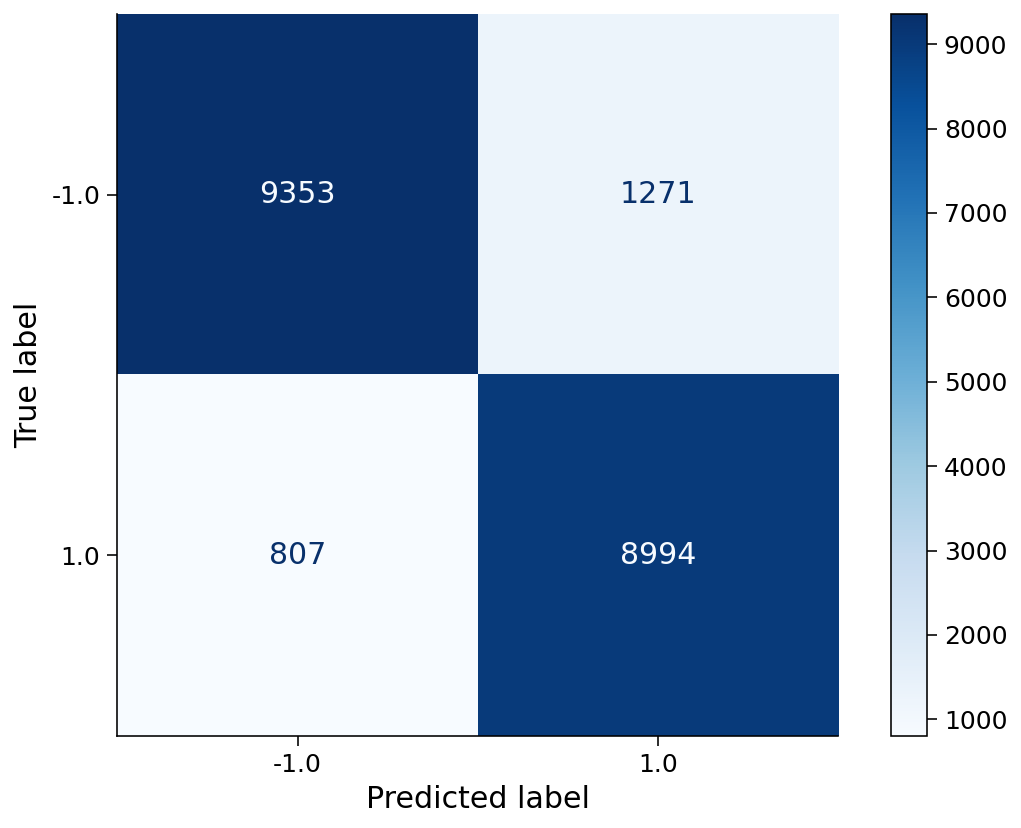

In [ ]:
print(x_test.shape)
print(y_test.shape)
np.set_printoptions(precision=1)
plot_confusion_matrix(clf_linearSVC, x_test, y_test, cmap=plt.cm.Blues, values_format = '')  # doctest: +SKIP
plt.show()

In [ ]:
def plot_weights(models, sharey=True):
  """Draw a stem plot of weights for each model in models dict."""
  n = len(models)
  f = plt.figure(figsize=(10, 2.5 * n))
  axs = f.subplots(n, sharex=True, sharey=sharey)
  axs = np.atleast_1d(axs)

  for ax, (title, model) in zip(axs, models.items()):

    ax.margins(x=.02)
    stem = ax.stem(model.coef_.squeeze(), use_line_collection=True)
    stem[0].set_marker(".")
    stem[0].set_color(".2")
    stem[1].set_linewidths(.5)
    stem[1].set_color(".2")
    stem[2].set_visible(False)
    ax.axhline(0, color="C3", lw=3)
    ax.set(ylabel="Weight", title=title)
  ax.set(xlabel="Voxel (a.k.a. feature)")
  f.tight_layout()

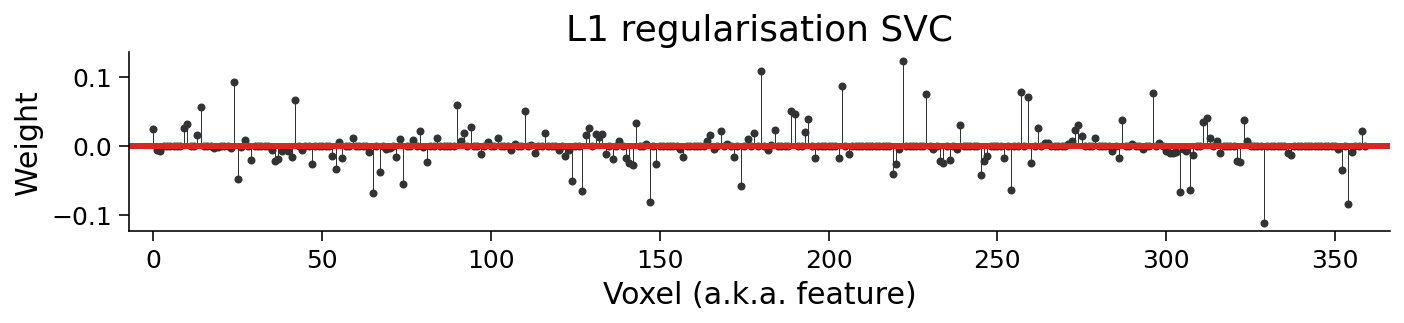

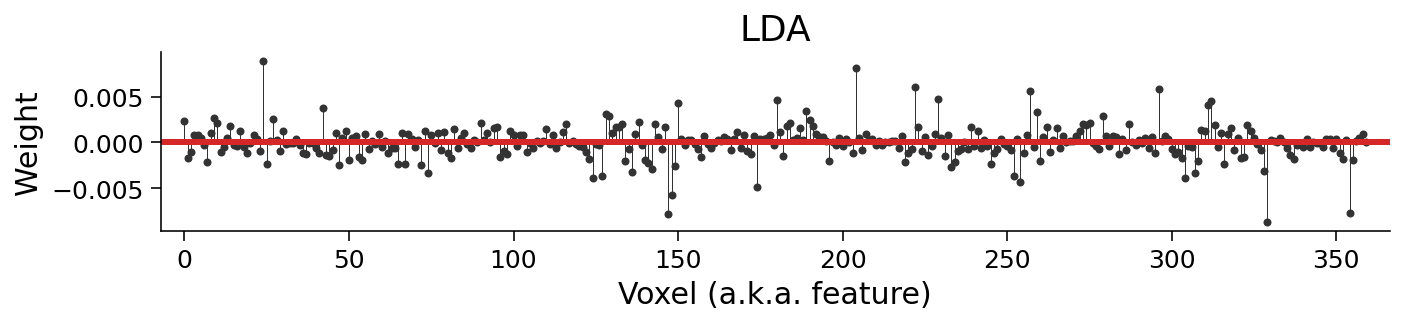

In [ ]:
# print(clf_linearSVC[1].coef_)
plot_weights({"L1 regularisation SVC": clf_linearSVC[1]})
plot_weights({"LDA": clf})

In [ ]:
l = abs(clf_linearSVC[1].coef_).argsort()[:,-10:]
print(l[0][::-1])
val = [ clf_linearSVC[1].coef_[0][i]*1000 for i in l]
print(val[0][::-1])
# print(clf.coef_[[0][257,229,174,296,222,354,329,147,24,204]])
print("Top distinguishing regions for math: ")
math_reg=[]
story_reg=[]
for r in l[0][val[0]>0]:
  math_reg = [region_info['name'][r]] + math_reg
print(math_reg)
print("Top distinguishing regions for story: ")
for r in l[0][val[0]<0]:
  story_reg = [region_info['name'][r]] + story_reg
print(story_reg)

[222 329 180  24 204 354 147 257 296 229]
[ 123.6 -110.9  107.7   92.8   86.1  -84.8  -81.6   78.2   77.    75.2]
Top distinguishing regions for math: 
['L_SCEF', 'L_V1', 'R_PSL', 'L_PSL', 'L_6r', 'L_AIP', 'L_MIP']
Top distinguishing regions for story: 
['L_PGi', 'L_A4', 'R_PF']


In [ ]:
svc_voxels = abs(clf_linearSVC[1].coef_[0]).argsort()[-10:][::-1]
print(svc_voxels)

[222 329 180  24 204 354 147 257 296 229]


In [ ]:
print(clf_linearSVC[1].coef_[0][svc_voxels])

[ 0.1 -0.1  0.1  0.1  0.1 -0.1 -0.1  0.1  0.1  0.1]


##PCA

In [ ]:
from sklearn.decomposition import PCA as sklearnPCA

pca_svc_accuracy = []
for i in range(1,6):
  sklearn_pca = sklearnPCA(n_components=i)
  X_pca = sklearn_pca.fit_transform(x_train)

  clf_PCA_SVC = LinearSVC(C =1.0, penalty='l2', dual=False, random_state=0, tol=1e-5, max_iter=10000)
  clf_PCA_SVC.fit(X_pca, y_train)

  X_pca_test = sklearn_pca.transform(x_test)
  y_pred_pca_svc = clf_PCA_SVC.predict(X_pca_test)
  cm_pca_svc = confusion_matrix(y_test, y_pred_pca_svc)
  print(cm_pca_svc)
  ascore=accuracy_score(y_test, y_pred_pca_svc)
  print('Accuracy' + str(ascore))
  pca_svc_accuracy.append(ascore)


[[8212 2412]
 [7576 2225]]
Accuracy0.5109914320685435
[[8602 2022]
 [1961 7840]]
Accuracy0.8049938800489596
[[8816 1808]
 [1473 8328]]
Accuracy0.8393635250917992
[[8825 1799]
 [1471 8330]]
Accuracy0.8399020807833537
[[8806 1818]
 [1413 8388]]
Accuracy0.8418115055079559


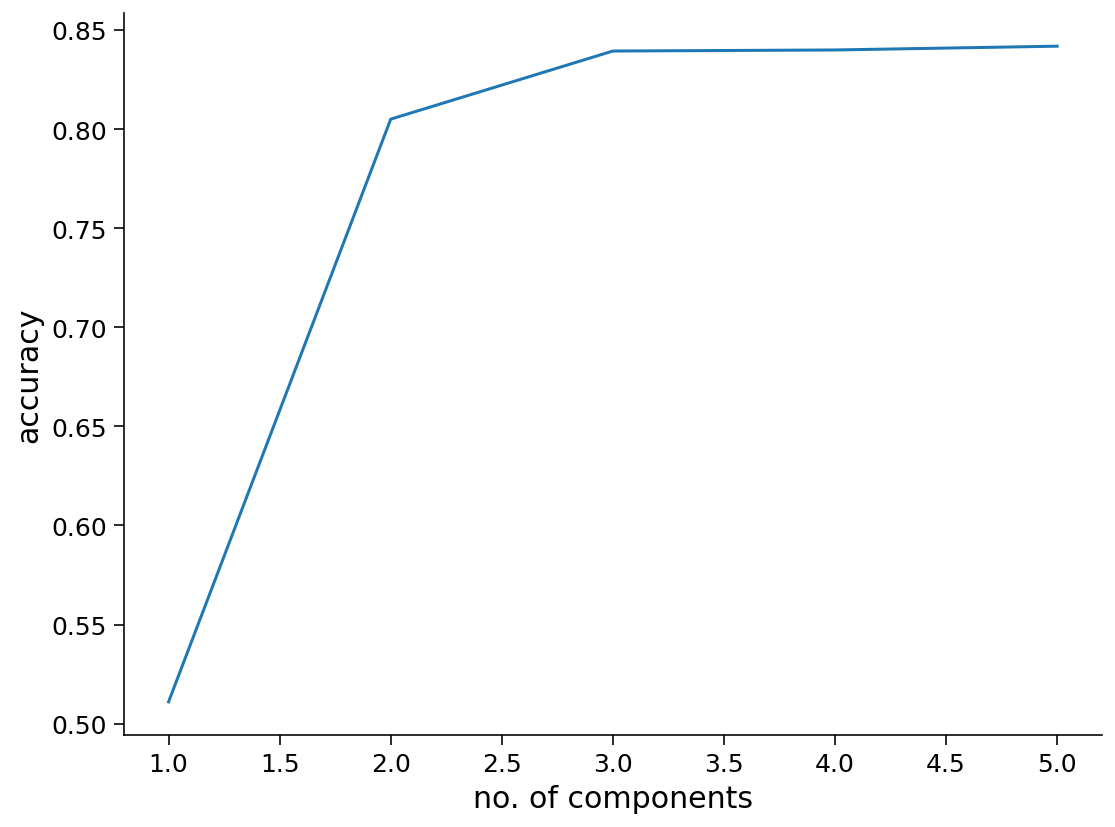

In [ ]:
plt.figure()
plt.xlabel('no. of components')
plt.ylabel('accuracy')
plt.plot(range(1,6),pca_svc_accuracy)

In [272]:
threshold_accuracy = []
no_parcels = []
for threshold in range(1,int(max(hemi_contrasts[0]))):
    imp_parcel = np.concatenate((np.where(hemi_contrasts[0]>threshold)[0], np.where(hemi_contrasts[1]>threshold)[0]+180))
    imp_parcel = np.concatenate((imp_parcel,np.where(hemi_contrasts[0]<-threshold)[0]))
    imp_parcel = np.concatenate((imp_parcel,np.where(hemi_contrasts[1]<-threshold)[0]+180))
    # print(imp_parcel)
    tx_train, tx_test, ty_train, ty_test = train_test_split(n_sub_timeseries[:,imp_parcel], n_sub_timeseries[:,-1], test_size=0.20, random_state=42)
    
    threshold_clf = LinearDiscriminantAnalysis(n_components=1, store_covariance=True)
    threshold_clf.fit(tx_train, ty_train)
    y_pred_threshold = threshold_clf.predict(tx_test)

    ascore=accuracy_score(ty_test, y_pred_threshold)
    print('Accuracy' + str(ascore))
    threshold_accuracy.append(ascore)
    no_parcels.append(len(imp_parcel))

Accuracy0.8987515299877601
Accuracy0.8986536107711138
Accuracy0.8978212974296206
Accuracy0.8976744186046511
Accuracy0.8971848225214198
Accuracy0.8965973072215422
Accuracy0.8946389228886169
Accuracy0.8936107711138311
Accuracy0.8942472460220319
Accuracy0.8934638922888617
Accuracy0.8924357405140759
Accuracy0.8909669522643819
Accuracy0.8904773561811505
Accuracy0.8900367197062423
Accuracy0.889155446756426
Accuracy0.8901835985312118
Accuracy0.8884700122399021
Accuracy0.8881762545899633
Accuracy0.8875887392900856
Accuracy0.8868543451652386
Accuracy0.8858261933904529
Accuracy0.8838678090575275
Accuracy0.8812239902080783
Accuracy0.8816156670746634
Accuracy0.8798041615667075
Accuracy0.879608323133415
Accuracy0.8769645042839658
Accuracy0.8760832313341493
Accuracy0.8749082007343941
Accuracy0.8738800489596084
Accuracy0.8731946144430844
Accuracy0.8729498164014687
Accuracy0.8718727050183599
Accuracy0.8656548347613219
Accuracy0.8648714810281518
Accuracy0.8659975520195838
Accuracy0.8631578947368421
Acc

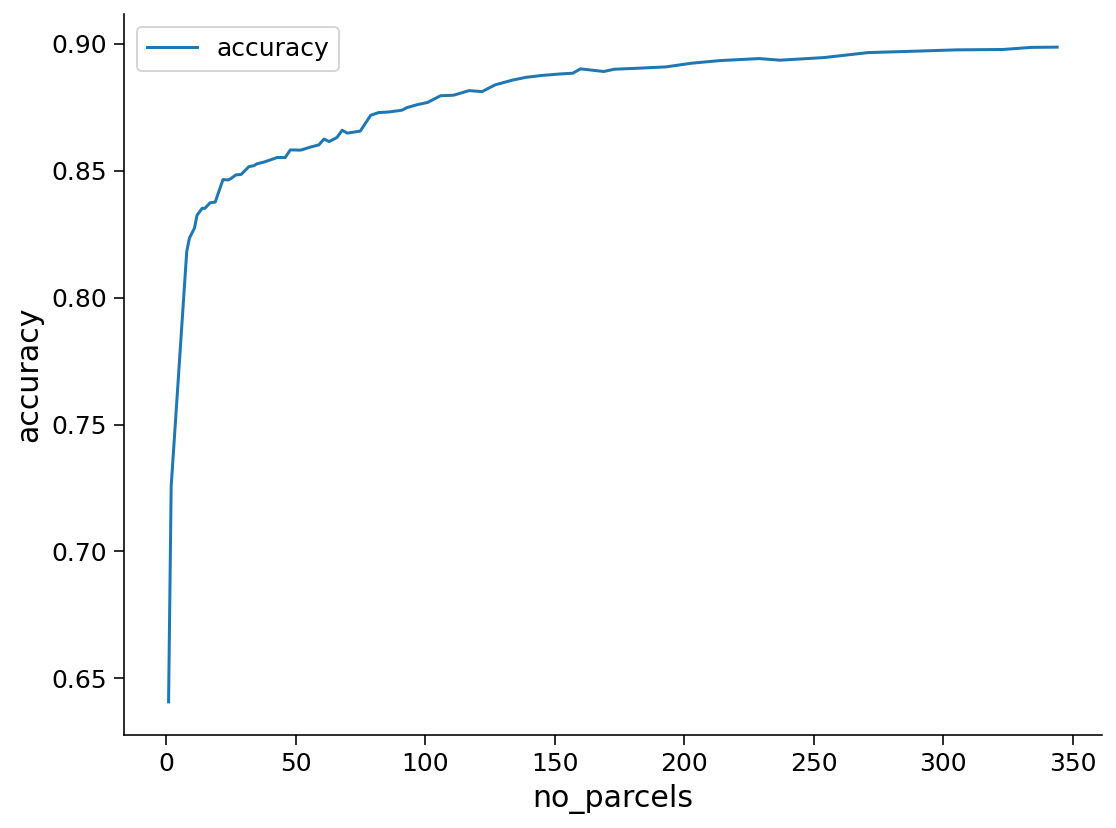

In [276]:
plt.figure()
plt.xlabel('no_parcels')
plt.ylabel('accuracy')
plt.plot(no_parcels, threshold_accuracy, label = "accuracy")
# plt.plot(range(1,int(max(hemi_contrasts[0]))), np.array(no_parcels)/360, 'r-', label = "fraction of parcels")
plt.legend()
plt.show()

In [274]:
threshold=63
imp_parcel = np.concatenate((np.where(hemi_contrasts[0]>threshold)[0], np.where(hemi_contrasts[1]>threshold)[0]+180))
imp_parcel = np.concatenate((imp_parcel,np.where(hemi_contrasts[0]<-threshold)[0]))
imp_parcel = np.concatenate((imp_parcel,np.where(hemi_contrasts[1]<-threshold)[0]+180))
print(imp_parcel)

[ 87 245 267 355  82 143 259 262 323]
